In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time 
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

4997
4990
4999
4995
4991
4998
4992
4996
4993
4994


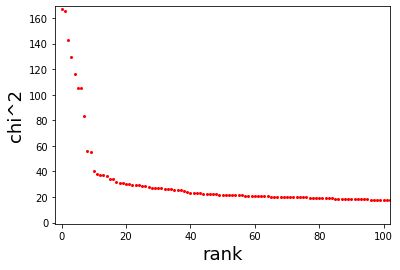

In [2]:
N = 500
M = 5000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
for i in range(10):
    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, stats, marker="o", markersize=2, color = "red", linestyle = "None")
#plt.axhline(33.6, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2", fontsize = 18)
fig.savefig("stats_large.png")
fig.savefig("fig/stats-large.eps")

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [12]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [13]:
def RankError(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    RE = np.zeros(4)
    for j in range(3):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 3
        
    return RE

[[2.40600000e+03 3.33333333e+00 2.85300000e+03 1.41733333e+03]
 [3.42800000e+03 5.33333333e+00 2.13266667e+03 2.35766667e+03]
 [3.42900000e+03 5.66666667e+00 2.50200000e+03 2.30200000e+03]
 [2.40366667e+03 2.33333333e+00 1.33333333e+00 1.00000000e+00]
 [3.10166667e+03 5.33333333e+00 3.33333333e-01 3.33333333e-01]
 [4.10966667e+03 6.66666667e+00 0.00000000e+00 1.00000000e+00]]
[[3.08766667e+03 7.66666667e+00 2.35566667e+03 2.84833333e+03]
 [3.44400000e+03 1.00000000e+00 2.63800000e+03 1.85500000e+03]
 [3.43766667e+03 4.33333333e+00 3.00733333e+03 2.95866667e+03]
 [2.74733333e+03 3.00000000e+00 0.00000000e+00 3.33333333e-01]
 [4.11900000e+03 4.00000000e+00 3.33333333e-01 1.00000000e+00]
 [3.42566667e+03 5.66666667e+00 6.66666667e-01 0.00000000e+00]]
[[2.40633333e+03 6.66666667e+00 1.32733333e+03 4.03000000e+03]
 [2.05300000e+03 2.66666667e+00 2.26833333e+03 3.72233333e+03]
 [2.22633333e+03 3.33333333e+00 3.25266667e+03 7.56000000e+02]
 [2.05200000e+03 4.33333333e+00 1.00000000e+00 2.6666

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[3.43333333e+03 7.66666667e+00 2.72400000e+03 1.26466667e+03]
 [2.75700000e+03 3.33333333e+00 2.03700000e+03 3.31766667e+03]
 [4.11433333e+03 4.33333333e+00 2.29400000e+03 6.81333333e+02]
 [3.42333333e+03 4.66666667e+00 6.10333333e+02 1.15333333e+03]
 [3.43766667e+03 3.66666667e+00 3.33333333e-01 3.33333333e-01]
 [3.08433333e+03 4.33333333e+00 6.66666667e-01 6.66666667e-01]]


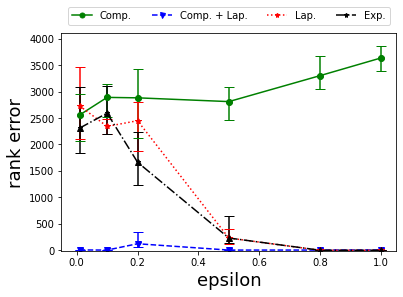

In [14]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 4100)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=1.png")
fig.savefig("fig/RE_large_K=1.eps")

[[2.97555556e+03 6.70333333e+02 2.08322222e+03 2.16888889e+03]
 [1.80688889e+03 1.27777778e+02 2.23077778e+03 2.54788889e+03]
 [2.97577778e+03 3.44444444e+00 2.88577778e+03 2.13388889e+03]
 [2.80622222e+03 5.33333333e+00 1.14211111e+03 1.74033333e+03]
 [2.74455556e+03 3.33333333e+00 2.39266667e+03 2.01788889e+03]
 [3.88544444e+03 4.11111111e+00 7.33000000e+02 1.39755556e+03]]
[[3.89200000e+03 4.33333333e+00 2.25111111e+03 2.97844444e+03]
 [2.23600000e+03 3.55555556e+00 1.94933333e+03 2.47133333e+03]
 [2.74266667e+03 1.09777778e+02 2.57700000e+03 2.66433333e+03]
 [2.11722222e+03 2.92333333e+02 2.16611111e+03 2.16066667e+03]
 [2.76177778e+03 2.88888889e+00 2.46988889e+03 1.69866667e+03]
 [3.09377778e+03 4.44444444e+00 9.17333333e+02 1.53088889e+03]]
[[3.53811111e+03 5.14777778e+02 2.89511111e+03 1.86188889e+03]
 [3.37377778e+03 4.00000000e+00 2.21300000e+03 2.45722222e+03]
 [2.40222222e+03 5.11111111e+00 2.28000000e+03 2.50566667e+03]
 [3.08966667e+03 3.88888889e+00 2.87711111e+03 2.5903

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[2.92344444e+03 4.33333333e+00 1.61977778e+03 2.15800000e+03]
 [2.57666667e+03 4.84666667e+02 2.81711111e+03 2.22977778e+03]
 [2.53300000e+03 6.06888889e+02 2.44600000e+03 3.23388889e+03]
 [2.62966667e+03 2.00000000e+00 2.07044444e+03 2.97777778e+03]
 [2.30255556e+03 3.88888889e+00 2.15777778e+03 1.70233333e+03]
 [2.20444444e+03 2.88888889e+00 1.35488889e+03 6.43333333e+02]]


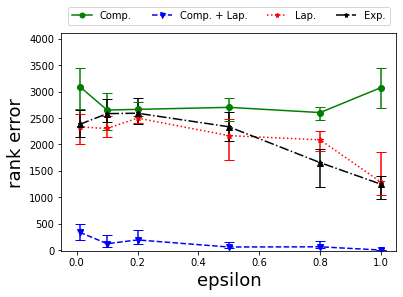

In [15]:
eta = 10
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 4100)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=3.png")
fig.savefig("fig/RE_large_K=3.eps")

[[2.40313333e+03 8.79200000e+02 2.63673333e+03 2.73426667e+03]
 [2.40033333e+03 4.58666667e+02 2.97513333e+03 2.49440000e+03]
 [2.65060000e+03 3.06666667e+00 2.43860000e+03 2.44233333e+03]
 [3.05733333e+03 9.21400000e+02 2.33500000e+03 2.47646667e+03]
 [2.90266667e+03 2.51866667e+02 2.60786667e+03 2.56026667e+03]
 [3.46306667e+03 1.20593333e+03 2.87400000e+03 2.13713333e+03]]
[[2866.66666667  508.06666667 2300.6        2370.        ]
 [2396.33333333  542.4        2920.46666667 2320.33333333]
 [2889.6         624.66666667 2059.         2504.06666667]
 [2554.2        1288.46666667 2796.6        2159.2       ]
 [2507.33333333  289.06666667 2499.4        2162.86666667]
 [2610.33333333  352.6        2196.         1969.2       ]]
[[2611.93333333  578.4        3305.4        2601.93333333]
 [2848.13333333  786.13333333 2293.13333333 2493.4       ]
 [2112.73333333  528.         2553.8        1915.13333333]
 [2688.33333333 1389.93333333 3001.93333333 2964.8       ]
 [3260.06666667  354.93333333 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[2329.73333333  457.93333333 2321.2        2288.33333333]
 [1998.8         795.73333333 2206.2        2661.06666667]
 [2898.13333333  228.6        2955.33333333 2183.8       ]
 [3322.86666667  665.33333333 2333.6        2379.        ]
 [2130.4           3.6        2237.8        2492.46666667]
 [2866.33333333  920.73333333 2510.46666667 1903.33333333]]


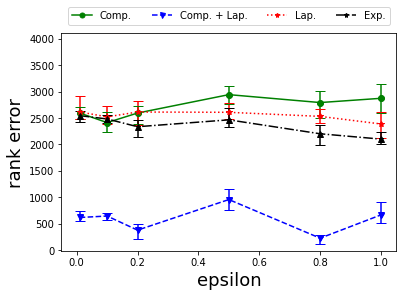

In [16]:
eta = 10
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 4100)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=5.png")
fig.savefig("fig/RE_large_K=5.eps")

[[2933.13333333 1741.         2397.66666667 2672.66666667]
 [3105.2        2089.33333333 2695.96666667 2628.66666667]
 [2957.33333333 1663.93333333 2787.2        2881.2       ]
 [2424.16666667 1431.06666667 2058.13333333 2501.06666667]
 [2757.76666667 1485.         2579.3        2724.33333333]
 [3324.93333333 1316.23333333 2349.26666667 2170.33333333]]
[[3039.2        1349.73333333 2594.9        2271.06666667]
 [2614.83333333 1565.9        2200.96666667 2845.33333333]
 [2840.06666667 1373.4        2788.06666667 2085.46666667]
 [2758.96666667 1032.1        2755.63333333 2292.13333333]
 [2954.8        1068.3        2863.3        2145.2       ]
 [3020.         1277.2        2546.36666667 2183.7       ]]
[[3177.7        1323.36666667 2574.4        2358.26666667]
 [2666.03333333 1754.93333333 2363.6        2322.33333333]
 [2190.63333333 2171.66666667 2146.83333333 2120.96666667]
 [2462.23333333 1143.3        2531.4        2900.83333333]
 [3226.56666667 2343.43333333 2318.5        2957.93333

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[3039.46666667 1087.43333333 2325.6        2137.6       ]
 [3025.63333333 1440.3        2775.03333333 2563.        ]
 [2760.43333333 1631.73333333 2624.1        3302.86666667]
 [2640.13333333 1193.1        2040.93333333 2803.06666667]
 [3188.26666667 1139.6        2335.         2594.96666667]
 [2834.76666667 1351.43333333 2443.63333333 2244.03333333]]


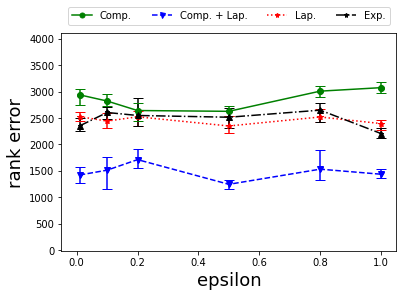

In [17]:
eta = 10
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-10, 4100)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=10.png")
fig.savefig("fig/RE_large_K=10.eps")